# Utils

In [6]:
import torch
import torch.nn as nn
import torchvision
import random 
import torch.optim as optim

from torchmetrics import StructuralSimilarityIndexMeasure

import os
from PIL import Image 
import math
import time 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import rotate
import numpy as np
from torch.utils.data import Dataset

from IPython.display import HTML
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch
from functools import partial

import ml_collections

def resetRandomStates(manualseed=47):
    print("In resetRandomStates(), set random seed =", manualseed)
    random.seed(manualseed)
    torch.manual_seed(manualseed)
    np.random.seed(manualseed)
    
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    h = math.floor(m / 60)
    m -= h * 60
    return '%dm %ds' % (m, s) if h==0 else '%dh %dm %ds' % (h, m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))     
    
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
    
def imshow(sample, sampling_number = 64):
    plt.figure(figsize=(10, 10))
#     clear_output()
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255
            
    show_sample = show_sample.astype(np.uint8)
    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()
    
def myimshow(sample, titletext="title", showImg=True):
    sampling_number = len(sample) 
    col_number = int(math.sqrt(sampling_number))
    img = torchvision.utils.make_grid(sample.detach().cpu(), nrow=col_number, padding=1, normalize=True, pad_value=0.9)
    img = np.transpose(img.numpy(), (1,2,0))
    img = img.astype(np.float32)
    if showImg:
        plt.figure()
#         clear_output()
        plt.title(titletext)
        if img.shape[2] == 1:
            plt.imshow(img, cmap="gray")
        elif img.shape[2] == 3:
            plt.imshow(img)
        plt.show()
    else:
        return img     
    
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
datasetname = "AFAD"
print(f"Running on device {device}; For dataset {datasetname}")

Running on device cuda:0; For dataset AFAD


# Define NCSN Configs

In [2]:
def get_default_configs(datasetname="CelebA"):
    if datasetname == "CelebA":
        config = ml_collections.ConfigDict()
        # training
        config.training = training = ml_collections.ConfigDict()
        config.training.batch_size = 128
        training.n_epochs = 500000 
        training.n_iters = 210001
        training.anneal_power = 2  

        # sampling
        config.sampling = sampling = ml_collections.ConfigDict()
        sampling.n_steps_each = 5  
        sampling.denoise = True
        sampling.step_lr = 0.0000033


        # evaluation
        config.test = test = ml_collections.ConfigDict()
        test.begin_ckpt = 5000
        test.end_ckpt = 210000
        test.batch_size = 100

       
        # model
        config.model = model = ml_collections.ConfigDict()
        model.sigma_begin = 90.0
        model.num_classes = 500 
        model.spec_norm = False 
        model.sigma_dist = 'geometric'
        model.sigma_end = 0.01 
        model.nonlinearity = "elu"
        model.normalization = "InstanceNorm++"
        model.ngf = 128

        # optimization
        config.optim = optim = ml_collections.ConfigDict()
        optim.weight_decay = 0
        optim.optimizer = "Adam"
        optim.lr = 0.0001
        optim.beta1 = 0.9
        optim.eps = 0.00000001
        optim.amsgrad = False
        
        
    elif datasetname == "CIFAR10":
        config = ml_collections.ConfigDict()
        # training
        config.training = training = ml_collections.ConfigDict()
        config.training.batch_size = 128
        training.n_epochs = 500000 
        training.n_iters = 300001
        training.anneal_power = 2  

        # sampling
        config.sampling = sampling = ml_collections.ConfigDict()
        sampling.n_steps_each = 5  
        sampling.denoise = True
        sampling.step_lr = 0.0000062


        # evaluation
        config.test = test = ml_collections.ConfigDict()
        test.begin_ckpt = 5000
        test.end_ckpt = 300000
        test.batch_size = 100

       
        # model
        config.model = model = ml_collections.ConfigDict()
        model.sigma_begin = 50
        model.num_classes = 232 
        model.spec_norm = False 
        model.sigma_dist = 'geometric'
        model.sigma_end = 0.01 
        model.nonlinearity = "elu"
        model.normalization = "InstanceNorm++"
        model.ngf = 128

        # optimization
        config.optim = optim = ml_collections.ConfigDict()
        optim.weight_decay = 0
        optim.optimizer = "Adam"
        optim.lr = 0.0001
        optim.beta1 = 0.9
        optim.eps = 0.00000001
        optim.amsgrad = False
        
        
        
    config.seed = 47
    config.device = device
    print("Running on device:", config.device)

    return config

def get_sigmas(config):
    if config.model.sigma_dist == 'geometric':
        sigmas = torch.tensor(
            np.exp(np.linspace(np.log(config.model.sigma_begin), np.log(config.model.sigma_end),
                               config.model.num_classes))).float().to(config.device)
    elif config.model.sigma_dist == 'uniform':
        sigmas = torch.tensor(
            np.linspace(config.model.sigma_begin, config.model.sigma_end, config.model.num_classes)
        ).float().to(config.device)

    else:
        raise NotImplementedError('sigma distribution not supported')

    return sigmas


def get_act(config):
    """Get activation functions from the config file."""

    if config.model.nonlinearity.lower() == "elu":
        return nn.ELU()
    elif config.model.nonlinearity.lower() == "relu":
        return nn.ReLU()
    elif config.model.nonlinearity.lower() == "lrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif config.model.nonlinearity.lower() == "swish":
        return nn.SiLU()
    else:
        raise NotImplementedError("activation function does not exist!")

class InstanceNorm2dPlus(nn.Module):
    def __init__(self, num_features, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(
            num_features, affine=False, track_running_stats=False
        )
        self.alpha = nn.Parameter(torch.zeros(num_features))
        self.gamma = nn.Parameter(torch.zeros(num_features))
        self.alpha.data.normal_(1, 0.02)
        self.gamma.data.normal_(1, 0.02)
        if bias:
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        means = torch.mean(x, dim=(2, 3))
        m = torch.mean(means, dim=-1, keepdim=True)
        v = torch.var(means, dim=-1, keepdim=True)
        means = (means - m) / (torch.sqrt(v + 1e-5))
        h = self.instance_norm(x)

        if self.bias:
            h = h + means[..., None, None] * self.alpha[..., None, None]
            out = self.gamma.view(-1, self.num_features, 1, 1) * h + self.beta.view(
                -1, self.num_features, 1, 1
            )
        else:
            h = h + means[..., None, None] * self.alpha[..., None, None]
            out = self.gamma.view(-1, self.num_features, 1, 1) * h
        return out


def get_normalization(config):
    norm = config.model.normalization
    if norm == "InstanceNorm++":
        return InstanceNorm2dPlus
    else:
        raise ValueError("Unknown normalization: %s" % norm)

def get_optimizer(config, parameters):
    if config.optim.optimizer == "Adam":
        return optim.Adam(
            parameters,
            lr=config.optim.lr,
            weight_decay=config.optim.weight_decay,
            betas=(config.optim.beta1, 0.999),
            amsgrad=config.optim.amsgrad,
            eps=config.optim.eps,
        )
    elif config.optim.optimizer == "RMSProp":
        return optim.RMSprop(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay)
    elif config.optim.optimizer == "SGD":
        return optim.SGD(parameters, lr=config.optim.lr, momentum=0.9)
    else:
        raise NotImplementedError("Optimizer {} not understood.".format(config.optim.optimizer))

config = get_default_configs()      
sigmas = torch.tensor(get_sigmas(config), device=config.device).float()

Running on device: cuda:0


/tmp/ipykernel_1212683/1737950210.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmas = torch.tensor(get_sigmas(config), device=config.device).float()


# Define NCSNv2 Network

- The diffusion (forward) phase

$$
x_t=x_0 + \sigma_t z
$$

$$\Delta_{x_t}\log q(x_t|x_0) = - \frac{x_t - x_0}{\sigma^2_t} = - \frac{z}{\sigma_t} $$

- The training phase

$$
\mathcal{L}(\theta, \{\sigma_t\}^T_{t=1}) = \frac{1}{T} \sum^T_{t=1} \lambda(\sigma_t) l(\theta, \sigma_t)
$$

$$
l(\theta, \sigma_t)=\frac{1}{2}\mathbb{E}_{p_{data}(x)} \mathbb{E}_{x_t\sim \mathcal{N}(x_0, \sigma_t^2 I)} \left[
||s_{\theta}(x_t, \sigma_t) + \frac{z}{\sigma_t} ||^2_2
\right]
$$

In [3]:
def spectral_norm(layer, n_iters=1):
    return torch.nn.utils.spectral_norm(layer, n_power_iterations=n_iters)

def conv1x1(in_planes, out_planes, stride=1, bias=True, spec_norm=False):
    "1x1 convolution"
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     padding=0, bias=bias)
    if spec_norm:
        conv = spectral_norm(conv)
    return conv


def conv3x3(in_planes, out_planes, stride=1, bias=True, spec_norm=False):
    "3x3 convolution with padding"
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=bias)
    if spec_norm:
        conv = spectral_norm(conv)

    return conv


def dilated_conv3x3(in_planes, out_planes, dilation, bias=True, spec_norm=False):
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=dilation, dilation=dilation, bias=bias)
    if spec_norm:
        conv = spectral_norm(conv)

    return conv

class CRPBlock(nn.Module):
    def __init__(self, features, n_stages, act=nn.ReLU(), maxpool=True, spec_norm=False):
        super().__init__()
        self.convs = nn.ModuleList()
        for i in range(n_stages):
            self.convs.append(conv3x3(features, features, stride=1, bias=False, spec_norm=spec_norm))
        self.n_stages = n_stages
        if maxpool:
            self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        else:
            self.maxpool = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)

        self.act = act

    def forward(self, x):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x



class RCUBlock(nn.Module):
    def __init__(self, features, n_blocks, n_stages, act=nn.ReLU(), spec_norm=False):
        super().__init__()

        for i in range(n_blocks):
            for j in range(n_stages):
                setattr(self, '{}_{}_conv'.format(i + 1, j + 1), conv3x3(features, features, stride=1, bias=False,
                                                                         spec_norm=spec_norm))

        self.stride = 1
        self.n_blocks = n_blocks
        self.n_stages = n_stages
        self.act = act

    def forward(self, x):
        for i in range(self.n_blocks):
            residual = x
            for j in range(self.n_stages):
                x = self.act(x)
                x = getattr(self, '{}_{}_conv'.format(i + 1, j + 1))(x)

            x += residual
        return x

class MSFBlock(nn.Module):
    def __init__(self, in_planes, features, spec_norm=False):
        """
        :param in_planes: tuples of input planes
        """
        super().__init__()
        assert isinstance(in_planes, list) or isinstance(in_planes, tuple)
        self.convs = nn.ModuleList()
        self.features = features

        for i in range(len(in_planes)):
            self.convs.append(conv3x3(in_planes[i], features, stride=1, bias=True, spec_norm=spec_norm))

    def forward(self, xs, shape):
        sums = torch.zeros(xs[0].shape[0], self.features, *shape, device=xs[0].device)
        for i in range(len(self.convs)):
            h = self.convs[i](xs[i])
            h = F.interpolate(h, size=shape, mode='bilinear', align_corners=True)
            sums += h
        return sums


class RefineBlock(nn.Module):
    def __init__(self, in_planes, features, act=nn.ReLU(), start=False, end=False, maxpool=True, spec_norm=False):
        super().__init__()

        assert isinstance(in_planes, tuple) or isinstance(in_planes, list)
        self.n_blocks = n_blocks = len(in_planes)

        self.adapt_convs = nn.ModuleList()
        for i in range(n_blocks):
            self.adapt_convs.append(
                RCUBlock(in_planes[i], 2, 2, act, spec_norm=spec_norm)
            )

        self.output_convs = RCUBlock(features, 3 if end else 1, 2, act, spec_norm=spec_norm)

        if not start:
            self.msf = MSFBlock(in_planes, features, spec_norm=spec_norm)

        self.crp = CRPBlock(features, 2, act, maxpool=maxpool, spec_norm=spec_norm)

    def forward(self, xs, output_shape):
        assert isinstance(xs, tuple) or isinstance(xs, list)
        hs = []
        for i in range(len(xs)):
            h = self.adapt_convs[i](xs[i])
            hs.append(h)

        if self.n_blocks > 1:
            h = self.msf(hs, output_shape)
        else:
            h = hs[0]

        h = self.crp(h)
        h = self.output_convs(h)

        return h

class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True, adjust_padding=False, spec_norm=False):
        super().__init__()
        if not adjust_padding:
            conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
            if spec_norm:
                conv = spectral_norm(conv)
            self.conv = conv
        else:
            conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
            if spec_norm:
                conv = spectral_norm(conv)

            self.conv = nn.Sequential(
                nn.ZeroPad2d((1, 0, 1, 0)),
                conv
            )

    def forward(self, inputs):
        output = self.conv(inputs)
        output = sum([output[:, :, ::2, ::2], output[:, :, 1::2, ::2],
                      output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return output

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, resample=None, act=nn.ELU(),
                 normalization=nn.BatchNorm2d, adjust_padding=False, dilation=None, spec_norm=False):
        super().__init__()
        self.non_linearity = act
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.resample = resample
        self.normalization = normalization
        if resample == 'down':
            if dilation is not None:
                self.conv1 = dilated_conv3x3(input_dim, input_dim, dilation=dilation, spec_norm=spec_norm)
                self.normalize2 = normalization(input_dim)
                self.conv2 = dilated_conv3x3(input_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation, spec_norm=spec_norm)
            else:
                self.conv1 = conv3x3(input_dim, input_dim, spec_norm=spec_norm)
                self.normalize2 = normalization(input_dim)
                self.conv2 = ConvMeanPool(input_dim, output_dim, 3, adjust_padding=adjust_padding, spec_norm=spec_norm)
                conv_shortcut = partial(ConvMeanPool, kernel_size=1, adjust_padding=adjust_padding, spec_norm=spec_norm)

        elif resample is None:
            if dilation is not None:
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation, spec_norm=spec_norm)
                self.conv1 = dilated_conv3x3(input_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
                self.normalize2 = normalization(output_dim)
                self.conv2 = dilated_conv3x3(output_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
            else:
                # conv_shortcut = nn.Conv2d ### Something wierd here.
                conv_shortcut = partial(conv1x1, spec_norm=spec_norm)
                self.conv1 = conv3x3(input_dim, output_dim, spec_norm=spec_norm)
                self.normalize2 = normalization(output_dim)
                self.conv2 = conv3x3(output_dim, output_dim, spec_norm=spec_norm)
        else:
            raise Exception('invalid resample value')

        if output_dim != input_dim or resample is not None:
            self.shortcut = conv_shortcut(input_dim, output_dim)

        self.normalize1 = normalization(input_dim)


    def forward(self, x):
        output = self.normalize1(x)
        output = self.non_linearity(output)
        output = self.conv1(output)
        output = self.normalize2(output)
        output = self.non_linearity(output)
        output = self.conv2(output)

        if self.output_dim == self.input_dim and self.resample is None:
            shortcut = x
        else:
            shortcut = self.shortcut(x)

        return shortcut + output
        
        
class NCSNv2(nn.Module):
    def __init__(self, config):
        super().__init__()
                                                          
                                            
        self.norm = get_normalization(config)
        self.ngf = ngf = config.model.ngf
        self.num_classes = num_classes = config.model.num_classes

        self.act = act = get_act(config)
        self.register_buffer('sigmas', get_sigmas(config))
        self.config = config

        self.begin_conv = nn.Conv2d(img_channels, ngf, 3, stride=1, padding=1)

        self.normalizer = self.norm(ngf, self.num_classes)
        self.end_conv = nn.Conv2d(ngf, img_channels, 3, stride=1, padding=1)

        self.res1 = nn.ModuleList([
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm),
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ResidualBlock(self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=2),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=2)]
        )

        if img_size == 28:
            self.res4 = nn.ModuleList([
                ResidualBlock(2 * self.ngf, 2 * self.ngf, resample='down', act=act,
                              normalization=self.norm, adjust_padding=True, dilation=4),
                ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                              normalization=self.norm, dilation=4)]
            )
        else:
            self.res4 = nn.ModuleList([
                ResidualBlock(2 * self.ngf, 2 * self.ngf, resample='down', act=act,
                              normalization=self.norm, adjust_padding=False, dilation=4),
                ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                              normalization=self.norm, dilation=4)]
            )

        self.refine1 = RefineBlock([2 * self.ngf], 2 * self.ngf, act=act, start=True)
        self.refine2 = RefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, act=act)
        self.refine3 = RefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, act=act)
        self.refine4 = RefineBlock([self.ngf, self.ngf], self.ngf, act=act, end=True)

    def _compute_cond_module(self, module, x):
        for m in module:
            x = m(x)
        return x

    def forward(self, x, y):
        h = 2 * x - 1.

        output = self.begin_conv(h)

        layer1 = self._compute_cond_module(self.res1, output)
        layer2 = self._compute_cond_module(self.res2, layer1)
        layer3 = self._compute_cond_module(self.res3, layer2)
        layer4 = self._compute_cond_module(self.res4, layer3)

        ref1 = self.refine1([layer4], layer4.shape[2:])
        ref2 = self.refine2([layer3, ref1], layer3.shape[2:])
        ref3 = self.refine3([layer2, ref2], layer2.shape[2:])
        output = self.refine4([layer1, ref3], layer1.shape[2:])

        output = self.normalizer(output)
        output = self.act(output)
        output = self.end_conv(output)

        used_sigmas = self.sigmas[y].view(x.shape[0], *([1] * len(x.shape[1:])))

        output = output / used_sigmas

        return output

# Define Datasets

## Define Hyperparameters

In [2]:
if datasetname in ("MNIST", "FashionMNIST"):
    img_channels = 1 
    img_size = 32
    img_class = 10 
    propName="Zero"
elif datasetname == "CelebA":
    img_channels = 3 
    img_size = 32 
    img_class = 2
    propName="Male"
elif datasetname == "AFAD":
    img_channels = 3 
    img_size = 32 
    img_class = 2
    propName="Young"    
elif datasetname == "CIFAR10":
    img_channels = 3 
    img_size = 32 
    img_class = 10 
    propName="Placeholder" 

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor()
])

print(f"For {datasetname} with property {propName}, Channels={img_channels}, Size={img_size}x{img_size}, Class={img_class}")

For AFAD with property Young, Channels=3, Size=32x32, Class=2


## Partial Dataset

In [8]:
"""
    Partial Property Class
"""
class AFADDataset(Dataset):

    def __init__(self, root_dir, names_file, transform=None):
        self.root_dir = root_dir
        self.names_file = names_file
        self.transform = transform
        self.size = 0
        self.names_list = []

        if not os.path.isfile(self.names_file):
            print(self.names_file + 'does not exist!')
        file = open(self.names_file)
        for f in file:
            self.names_list.append(f)
            self.size += 1

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        image_path = self.root_dir + self.names_list[idx].split(' ')[0]
        if not os.path.isfile(image_path):
            print(image_path + 'does not exist!')
            return None
        image = Image.open(image_path)   # use skitimage
        label = int(self.names_list[idx].split(' ')[1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
     
class PartialPropertyDataset(Dataset):

    def __init__(self, sampleNum, propRatio, split="train", datasetname="CelebA", repeatChannel=False):
        """
            split (string): One of {‘train’, ‘test’}
        """
        if split == "train":
            trainflag = True
            trainflagstr = split 
        elif split == "test":
            trainflag = False
            trainflagstr = split
        resetRandomStates()
        self.repeatChannel = repeatChannel
        if datasetname == "MNIST":  
            fulldataset = torchvision.datasets.MNIST(root='./datasets', train=trainflag, download=False, transform = transform)
        elif datasetname == "FashionMNIST":
            fulldataset = torchvision.datasets.FashionMNIST(root='./datasets', train=trainflag, download=False, transform = transform)
        elif datasetname == "CelebA":
            fulldataset = torchvision.datasets.CelebA(root="./datasets", split=trainflagstr, download=False, transform=transform)
        elif datasetname == "CIFAR10":
            fulldataset = torchvision.datasets.CIFAR10(root='./datasets', train=trainflag, download=False, transform = transform)
        elif datasetname == "AFAD":
            fulldataset = AFADDataset(root_dir='./', names_file='./datasets/AFAD-Full/two-properties-diffusion.txt', transform=transform)
            
        fullloader = torch.utils.data.DataLoader(fulldataset, batch_size = len(fulldataset), shuffle=False)
        fullimgs, fulllabels = next(iter(fullloader))
        if datasetname == "CelebA":
            fulllabels = fulllabels[:, 20].squeeze()
        newsetlen = sampleNum 
        propNum = int(sampleNum*propRatio)  # num of images with target property
        b, c, h, w = fullimgs.size()
        self.partialimgs = torch.zeros(newsetlen, c, h, w)
        self.partiallabels = torch.zeros(newsetlen)
        accidx = 0
        propidx = 0 
        nonpropidx = 0 
        for i in range(len(fullimgs)):
            if (fulllabels[i] == 1 and propidx < propNum):
                self.partialimgs[accidx] = fullimgs[i]
                self.partiallabels[accidx] = fulllabels[i] 
                accidx += 1      
                propidx += 1 
            elif fulllabels[i] == 0 and nonpropidx < newsetlen - propNum:
                self.partialimgs[accidx] = fullimgs[i]
                self.partiallabels[accidx] = fulllabels[i] 
                accidx += 1
                nonpropidx += 1
            if accidx == newsetlen:
                break    
                
        if self.repeatChannel:
            assert img_channels == 1, "img_channels abnormal"
            self.partialimgs = self.partialimgs.repeat(1, 3, 1, 1)
       
    def __len__(self):
        return len(self.partialimgs)
    
    def __getitem__(self, index):
        return self.partialimgs[index], self.partiallabels[index]    

# fullClassTrain = False   

# usemember = True
# partialdataset = PartialDataset(datasetname, img_class, upperhalf=usemember)

sampleNum = 6000 
propRatio = 0.5

rpchn = (datasetname in ("MNIST", "FashionMNIST"))

partialdataset = PartialPropertyDataset(sampleNum, propRatio, split="train", datasetname=datasetname, repeatChannel=rpchn)
dataloader = torch.utils.data.DataLoader(partialdataset, batch_size=64, shuffle=True, num_workers=4)

print("Dataset: {}; Classes: {}; Channels: {}; Image Size: {}".format(datasetname, img_class, img_channels, img_size))
print("Dataset length: {}; Images with property: {}".format(len(partialdataset.partiallabels), (partialdataset.partiallabels).sum())) 

In resetRandomStates(), set random seed = 47
Dataset: AFAD; Classes: 2; Channels: 3; Image Size: 32
Dataset length: 6000; Images with property: 3000.0


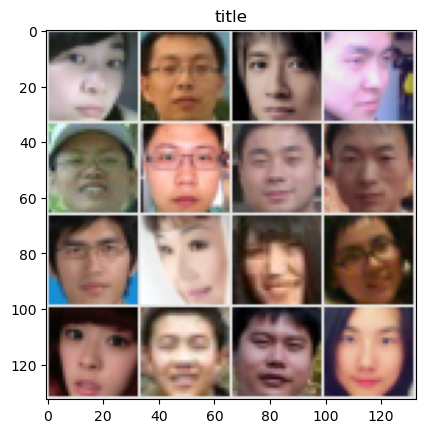

In [9]:
myimshow(partialdataset.partialimgs[:16])

# Train Diffusion - NCSN

## Start Training 

In [5]:
def anneal_dsm_score_estimation(scorenet, samples, sigmas, labels=None, anneal_power=2.0):
    if labels is None:
        labels = torch.randint(0, len(sigmas), (samples.shape[0],), device=samples.device)
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    noise = torch.randn_like(samples) * used_sigmas
    perturbed_samples = samples + noise
    target = -1 / (used_sigmas**2) * noise
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2.0 * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    return loss.mean(dim=0)


def anneal_Langevin_dynamics(x_mod, scorenet, sigmas, n_steps_each=200, step_lr=0.000008,
                             final_only=False, verbose=False, denoise=True):
    images = []

    with torch.no_grad():
        for c, sigma in enumerate(sigmas):
#             print("c=", c)
            labels = torch.ones(x_mod.shape[0], device=x_mod.device) * c
            labels = labels.long()
            step_size = step_lr * (sigma / sigmas[-1]) ** 2
            for s in range(n_steps_each):
#                 print("x_mod.dtype", x_mod.dtype)
                grad = scorenet(x_mod, labels).float() 
                
                

                noise = torch.randn_like(x_mod)
#                 print("noise.dtype:", noise.dtype)
                grad_norm = torch.norm(grad.view(grad.shape[0], -1), dim=-1).mean()
                noise_norm = torch.norm(noise.view(noise.shape[0], -1), dim=-1).mean()
                x_mod = x_mod + step_size * grad + noise * np.sqrt(step_size * 2)
                
#                 print("grad.dtype", grad.dtype)
                image_norm = torch.norm(x_mod.view(x_mod.shape[0], -1), dim=-1).mean()
                snr = np.sqrt(step_size / 2.) * grad_norm / noise_norm
                grad_mean_norm = torch.norm(grad.mean(dim=0).view(-1)) ** 2 * sigma ** 2

                if not final_only:
                    images.append(x_mod.to('cpu'))
                if verbose:
                    print("level: {}, step_size: {}, grad_norm: {}, image_norm: {}, snr: {}, grad_mean_norm: {}".format(
                        c, step_size, grad_norm.item(), image_norm.item(), snr.item(), grad_mean_norm.item()))

        if denoise:
            last_noise = (len(sigmas) - 1) * torch.ones(x_mod.shape[0], device=x_mod.device)
            last_noise = last_noise.long()
            x_mod = x_mod + sigmas[-1] ** 2 * scorenet(x_mod, last_noise)
            images.append(x_mod.to('cpu'))

        if final_only:
            return x_mod.to('cpu')
        else:
            return images

Running on device: cuda:0
In resetRandomStates(), set random seed = 47


/tmp/ipykernel_1662645/1666316799.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmas = torch.tensor(get_sigmas(config), device=config.device).float()


Dataset length: 6000; Images with property: 600.0
NCSNv2 CelebA Male 6000 0.1
In epoch 1 / 3000, time passed: 0m 15s (- 12h 41m 44s), loss is 325.5446472167969
In epoch 501 / 3000, time passed: 1h 43m 11s (- 8h 34m 42s), loss is 112.90866088867188


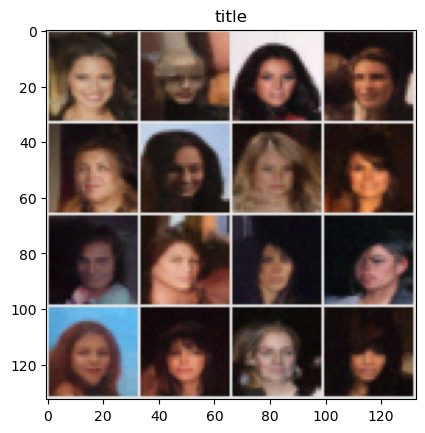

In epoch 1001 / 3000, time passed: 3h 26m 49s (- 6h 53m 2s), loss is 81.47794342041016


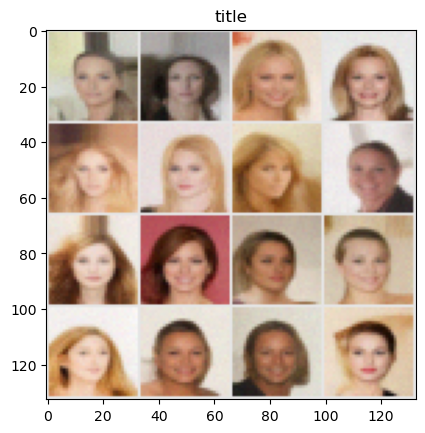

In epoch 1501 / 3000, time passed: 5h 10m 21s (- 5h 9m 56s), loss is 55.99095153808594


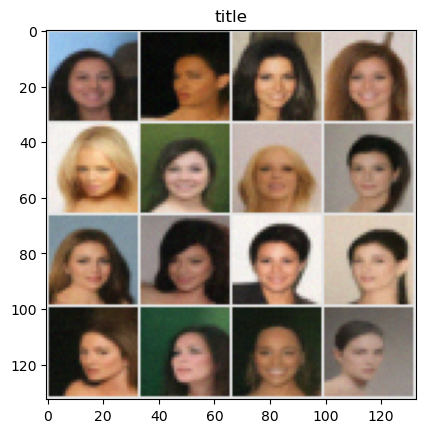

In epoch 2001 / 3000, time passed: 6h 53m 38s (- 3h 26m 30s), loss is 56.48723602294922


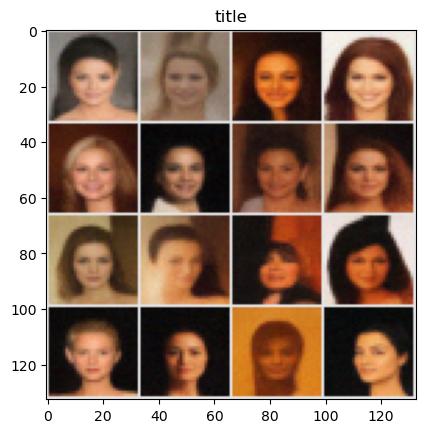

In epoch 2501 / 3000, time passed: 8h 37m 7s (- 1h 43m 10s), loss is 59.415077209472656


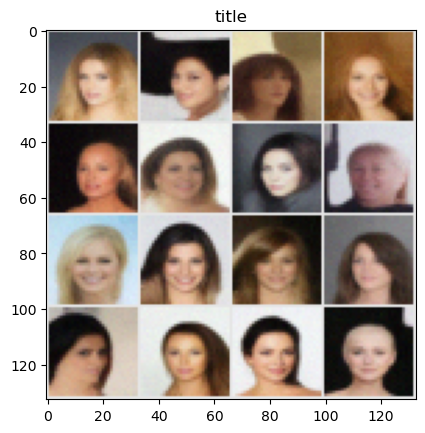

All finished!


In [8]:
n_epochs = 3000   # default 500000 
# 5000 + 
fixed_noises = torch.rand(16, img_channels, img_size, img_size, device=config.device)
modelname = "NCSNv2"
config = get_default_configs()
propName="Male"
sampleNum = 6000 

for propRatio in (0.1, ):
    score = NCSNv2(config).to(config.device) 
    score = torch.nn.DataParallel(score)
    sigmas = torch.tensor(get_sigmas(config), device=config.device).float()
    optimizer = get_optimizer(config, score.parameters())

    # propRatio = 0.9

    partialdataset = PartialPropertyDataset(sampleNum, propRatio, split="train", datasetname="CelebA")
    print("Dataset length: {}; Images with property: {}".format(len(partialdataset.partiallabels), (partialdataset.partiallabels).sum())) 
    dataloader = torch.utils.data.DataLoader(partialdataset, batch_size=config.training.batch_size, shuffle=True, num_workers=4)
    
    print(modelname, datasetname, propName, sampleNum, propRatio)

    starttime = time.time()

    time_print_interval = 500


    for epoch in range(1, n_epochs+1):
        for i, (X, y) in enumerate(dataloader):
            score.train()

            X = X.to(config.device)

            loss = anneal_dsm_score_estimation(score, X, sigmas, labels=None)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    #         print(loss)  
        if epoch % time_print_interval == 1:
            print("In epoch {} / {}, time passed: {}, loss is {}".format(epoch, n_epochs, timeSince(starttime, float(epoch)/n_epochs), loss.data))        
            if epoch > 1:
                score.eval()
                with torch.no_grad():
                    all_samples = anneal_Langevin_dynamics(fixed_noises, score, sigmas.cpu().numpy(), config.sampling.n_steps_each,
                                                        config.sampling.step_lr, final_only=True, verbose=False, denoise=False)

                    myimshow(all_samples)
                # save model
                torch.save(score.state_dict(), "models/{}-Diffusion-{}-{}-{}-{}.pt".format(modelname, datasetname, propName, sampleNum, propRatio))

    torch.save(score.state_dict(), "models/{}-Diffusion-{}-{}-{}-{}.pt".format(modelname, datasetname, propName, sampleNum, propRatio))
print("All finished!") 

### Save (Load) Model

In [7]:
# torch.save(score.state_dict(), "models/{}-Diffusion-{}-Train-{}.pt".format(modelname, datasetname, classtr))

score.load_state_dict(torch.load("models/NCSNv2-Diffusion-CelebA-Train-Multiclass.pt"))

<All keys matched successfully>

# Train SNGAN

In [11]:
import torch_mimicry as mmc
from torch_mimicry.nets import sngan

# Define models and optimizers
modelname = "SNGAN"
netG = sngan.SNGANGenerator32().to(device)
netD = sngan.SNGANDiscriminator32().to(device)
optD = torch.optim.Adam(netD.parameters(), 2e-4, betas=(0.0, 0.9))
optG = torch.optim.Adam(netG.parameters(), 2e-4, betas=(0.0, 0.9))


2023-05-02 13:03:07.334116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 13:03:07.887098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Delete Cached Logs

In [12]:
! rm -r ./log/example1 

## Start Training

In [13]:
# Start training
trainer = mmc.training.Trainer(
    netD=netD,
    netG=netG,
    optD=optD,
    optG=optG,
    n_dis=5,
    num_steps=15000,
    lr_decay='linear',
    dataloader=dataloader,
    log_dir='./log/example1',
    print_steps=400,
    device=device)
trainer.train()

INFO: Starting training from global step 0...
INFO: [Epoch 4/159][Global Step: 400/15000] 
| D(G(z)): 0.1426
| D(x): 0.4301
| errD: 1.3397
| errG: -0.7846
| lr_D: 0.000195
| lr_G: 0.000195
| (0.3717 sec/idx)
INFO: [Epoch 8/159][Global Step: 800/15000] 
| D(G(z)): 0.3463
| D(x): 0.5144
| errD: 1.4236
| errG: 0.3661
| lr_D: 0.000189
| lr_G: 0.000189
| (0.3655 sec/idx)
INFO: [Epoch 12/159][Global Step: 1200/15000] 
| D(G(z)): 0.2981
| D(x): 0.5785
| errD: 0.9813
| errG: -0.0463
| lr_D: 0.000184
| lr_G: 0.000184
| (0.3641 sec/idx)
INFO: [Epoch 17/159][Global Step: 1600/15000] 
| D(G(z)): 0.261
| D(x): 0.4671
| errD: 1.3435
| errG: 0.3239
| lr_D: 0.000179
| lr_G: 0.000179
| (0.3682 sec/idx)
INFO: [Epoch 21/159][Global Step: 2000/15000] 
| D(G(z)): 0.6297
| D(x): 0.8246
| errD: 1.6417
| errG: 1.4307
| lr_D: 0.000173
| lr_G: 0.000173
| (0.3741 sec/idx)
INFO: [Epoch 25/159][Global Step: 2400/15000] 
| D(G(z)): 0.5464
| D(x): 0.7887
| errD: 1.2803
| errG: 1.4859
| lr_D: 0.000168
| lr_G: 0.00016

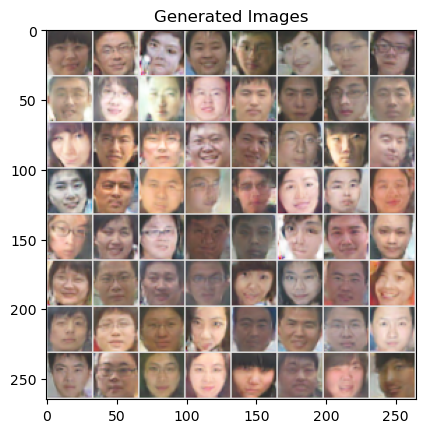

In [14]:
# Plot the fake images from the last epoch
noise = torch.randn(64, 128, device=device)
myimshow(netG(noise), titletext="Generated Images")

## Save Model

In [16]:
print(modelname, datasetname, propName, sampleNum, propRatio)
        
torch.save(netG.state_dict(), "models/{}-Generator-{}-{}-{}-{}.pt".format(modelname, datasetname, propName, sampleNum, propRatio))
torch.save(netD.state_dict(), "models/{}-Discriminator-{}-{}-{}-{}.pt".format(modelname, datasetname, propName, sampleNum, propRatio))

SNGAN AFAD Young 6000 0.5


# Train SSGAN

In [52]:
import torch_mimicry as mmc
from torch_mimicry.nets import ssgan

# Define models and optimizers
modelname = "SSGAN"
netG = ssgan.SSGANGenerator32().to(device)
netD = ssgan.SSGANDiscriminator32().to(device)
optD = torch.optim.Adam(netD.parameters(), 1e-4, betas=(0.0, 0.9))
optG = torch.optim.Adam(netG.parameters(), 1e-4, betas=(0.0, 0.9))

# loadpth = "models/{}-Generator-{}-{}-{}-{}.pt".format(modelname, datasetname, propName, sampleNum, propRatio)
# print(loadpth)
# netG.load_state_dict(torch.load(loadpth))

models/SSGAN-Generator-AFAD-Young-6000-0.5.pt


<All keys matched successfully>

## Delete Cached Parameters

In [6]:
! rm -r ./log/example2

rm: cannot remove './log/example2': No such file or directory


## Start Training

In [7]:
# Start training
trainer = mmc.training.Trainer(
    netD=netD,
    netG=netG,
    optD=optD,
    optG=optG,
    n_dis=5,
    num_steps=20000,
    lr_decay='linear',
    dataloader=dataloader,
    log_dir='./log/example2',
    print_steps=2000,
    device=device)
trainer.train()

INFO: Starting training from global step 0...
INFO: [Epoch 42/425][Global Step: 2000/20000] 
| D(G(z)): 0.5519
| D(x): 0.7532
| errD: 1.3594
| errD_SS: 0.0269
| errG: 1.0355
| errG_SS: 0.0046
| lr_D: 9e-05
| lr_G: 9e-05
| (0.7799 sec/idx)
INFO: [Epoch 85/425][Global Step: 4000/20000] 
| D(G(z)): 0.1538
| D(x): 0.3459
| errD: 1.6977
| errD_SS: 0.0162
| errG: -0.2848
| errG_SS: 0.0029
| lr_D: 8e-05
| lr_G: 8e-05
| (0.7799 sec/idx)
INFO: Saving checkpoints...
INFO: [Epoch 127/425][Global Step: 6000/20000] 
| D(G(z)): 0.2438
| D(x): 0.4681
| errD: 1.2353
| errD_SS: 0.0085
| errG: -0.0101
| errG_SS: 0.0022
| lr_D: 7e-05
| lr_G: 7e-05
| (0.7805 sec/idx)
INFO: [Epoch 170/425][Global Step: 8000/20000] 
| D(G(z)): 0.4818
| D(x): 0.79
| errD: 1.002
| errD_SS: 0.0068
| errG: 1.4863
| errG_SS: 0.0004
| lr_D: 6e-05
| lr_G: 6e-05
| (0.7822 sec/idx)
INFO: [Epoch 212/425][Global Step: 10000/20000] 
| D(G(z)): 0.1634
| D(x): 0.5195
| errD: 0.9685
| errD_SS: 0.0063
| errG: 0.1346
| errG_SS: 0.0004
| lr_

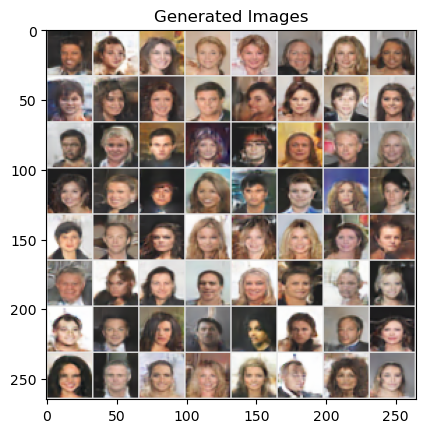

In [8]:
# Plot the fake images from the last epoch
noise = torch.randn(64, 128, device=device)
myimshow(netG(noise), titletext="Generated Images")

## Save Model

In [9]:
print(modelname, datasetname, propName, sampleNum, propRatio)
        
torch.save(netG.state_dict(), "models/{}-Generator-{}-{}-{}-{}.pt".format(modelname, datasetname, propName, sampleNum, propRatio))
torch.save(netD.state_dict(), "models/{}-Discriminator-{}-{}-{}-{}.pt".format(modelname, datasetname, propName, sampleNum, propRatio))

SSGAN CelebA Male 6000 0.5


# Black-box Attack with an Auxiliary Dataset

## Define Property Dataset

In [17]:
"""
    Property Classification Class
"""

class PropertyClassifierDataset(Dataset):

    def __init__(self, datasetname="CelebA", split="train", propRatio=0.5, sampleNum=None, repeatChannel=False):
        resetRandomStates()
        if split == "train":
            trainflag = True
            trainflagstr = split 
        elif split == "test":
            trainflag = False
            trainflagstr = split
        resetRandomStates()
        self.repeatChannel = repeatChannel
        if datasetname == "MNIST":  
            fulldataset = torchvision.datasets.MNIST(root='./datasets', train=trainflag, download=False, transform = transform)
        elif datasetname == "FashionMNIST":
            fulldataset = torchvision.datasets.FashionMNIST(root='./datasets', train=trainflag, download=False, transform = transform)
        elif datasetname == "CelebA":
            fulldataset = torchvision.datasets.CelebA(root="./datasets", split=trainflagstr, download=False, transform=transform)
        elif datasetname == "CIFAR10":
            fulldataset = torchvision.datasets.CIFAR10(root='./datasets', train=trainflag, download=False, transform = transform)
        elif datasetname == "AFAD":
            fulldataset = AFADDataset(root_dir='./', names_file='./datasets/AFAD-Full/two-properties-classifier.txt', transform=transform)
            
        fullloader = torch.utils.data.DataLoader(fulldataset, batch_size = len(fulldataset), shuffle=False)
        fullimgs, fulllabels = next(iter(fullloader))
        if datasetname == "CelebA":
            fulllabels = fulllabels[:, 20].squeeze()
        newsetlen = sampleNum 
        propNum = int(sampleNum*propRatio)  # num of images with target property
        b, c, h, w = fullimgs.size()
        self.partialimgs = torch.zeros(newsetlen, c, h, w)
        self.partiallabels = torch.zeros(newsetlen)
        accidx = 0
        propidx = 0 
        nonpropidx = 0 
        for i in range(len(fullimgs)):
            if (fulllabels[i] == 1 and propidx < propNum):
                self.partialimgs[accidx] = fullimgs[i]
                self.partiallabels[accidx] = fulllabels[i] 
                accidx += 1      
                propidx += 1 
            elif fulllabels[i] == 0 and nonpropidx < newsetlen - propNum:
                self.partialimgs[accidx] = fullimgs[i]
                self.partiallabels[accidx] = fulllabels[i] 
                accidx += 1
                nonpropidx += 1
            if accidx == newsetlen:
                break    
                
        if self.repeatChannel:
            assert img_channels == 1, "img_channels abnormal"
            self.partialimgs = self.partialimgs.repeat(1, 3, 1, 1)
       
    def __len__(self):
        return len(self.partialimgs)
    
    def __getitem__(self, index):
        return self.partialimgs[index], self.partiallabels[index]    


rpchn = (datasetname in ("MNIST", "FashionMNIST"))
propertyDatasets = PropertyClassifierDataset(datasetname=datasetname, split="train", propRatio=0.5, sampleNum=20000, repeatChannel=rpchn)

train_size = int(0.8 * len(propertyDatasets))
test_size = len(propertyDatasets) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(propertyDatasets, [train_size, test_size])


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

print("len(propertyDatasets):", len(propertyDatasets), "; Number of property images:", sum(propertyDatasets.partiallabels))  

In resetRandomStates(), set random seed = 47
In resetRandomStates(), set random seed = 47
len(propertyDatasets): 20000 ; Number of property images: tensor(10000.)


## Define Classifier

In [18]:
class PropertyClassifier(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 50)
        self.fc3 = nn.Linear(50, n_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


model = PropertyClassifier(n_channels=3, n_classes=2)


## Train the Classifier

In [19]:
def check_test_accuracy(mymodel, dataloader):
    mymodel.eval()
    accur = 0.0
    base = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            yhat = mymodel(x)
            accur += ( (yhat.argmax(dim=1)) == y ).sum()
            base += x.shape[0]
    return accur / base

model = PropertyClassifier(n_channels=3, n_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 20
test_interval = int(epochs / 5)

for epoch in range(epochs):
    model.train()
    accurate = 0.0
    train_accur_base = 0.0
    for x, y in trainloader: 
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_fn(yhat, y.long())
        loss.backward()
        optimizer.step()
        accurate += ((yhat.argmax(dim=1))==y).sum()  
        train_accur_base += x.shape[0]

    if epoch % test_interval == 0 or epoch == epochs - 1:
        # for each epoch, print information
        train = accurate / train_accur_base
        test = check_test_accuracy(model, testloader)
        print("In epoch {}, train accur is {}, test accur is {}.".format(epoch, train, test))

# torch.save(model.state_dict(), "models/PropertyClassifier-{}.pt".format(datasetname))        
print("All finished!")  

In epoch 0, train accur is 0.5687500238418579, test accur is 0.6502500176429749.
In epoch 4, train accur is 0.7205000519752502, test accur is 0.7207500338554382.
In epoch 8, train accur is 0.7394375205039978, test accur is 0.7420000433921814.
In epoch 12, train accur is 0.7473750114440918, test accur is 0.7452500462532043.
In epoch 16, train accur is 0.7613750100135803, test accur is 0.7565000653266907.
In epoch 19, train accur is 0.7659375071525574, test accur is 0.7555000185966492.
All finished!


## Black-Box Property Attack

### Generate Samples from Generative Model

In [53]:
resetRandomStates()
# score = NCSNv2(config).to(config.device) 
# score = torch.nn.DataParallel(score)
# score.load_state_dict(torch.load("models/NCSNv2-Diffusion-CelebA-Male-6000-0.5.pt"))   
# score = score.to(device)
# score.eval()
# model = PropertyClassifier(n_channels=3, n_classes=2).to(device)
# model.load_state_dict(torch.load("models/PropertyClassifier-CelebA.pt"))



all_samples = None 
sampNum = 2000 
batchNum = 512

for startidx in range(0, sampNum, batchNum):
    endidx = startidx + batchNum 
    if endidx > sampNum:
        endidx = sampNum 
        
#     fixed_noises = torch.rand(endidx-startidx, img_channels, img_size, img_size, device=config.device)
    fixed_noises = torch.randn(endidx-startidx, 128, device=device)
    with torch.no_grad():
#         batch_samples = anneal_Langevin_dynamics(fixed_noises, score, sigmas.cpu().numpy(), config.sampling.n_steps_each,
#                                             config.sampling.step_lr, final_only=True, verbose=False, denoise=False)
        batch_samples = netG(fixed_noises)
    if all_samples is None:
        all_samples = batch_samples
    else:
        all_samples = torch.cat((all_samples, batch_samples), dim=0)
        
    
    print(f"Finished processing samples {startidx}-{endidx}")
print(all_samples.shape)
print("All finished!")

In resetRandomStates(), set random seed = 47
Finished processing samples 0-512
Finished processing samples 512-1024
Finished processing samples 1024-1536
Finished processing samples 1536-2000
torch.Size([2000, 3, 32, 32])
All finished!


### Predict Property by Classifier

In [55]:
# all_samples = norm_all_samples
yhat = model(all_samples.to(device))
propertyPrediction = yhat.argmax(dim=1) 

In [34]:
queryNum = 200 
for i in range(10):
    startidx = i*queryNum 
    endidx = startidx+queryNum
    print(f"Exp {i}, extimated ratio {propertyPrediction[startidx:endidx].sum()/(1.*queryNum)}")

Exp 0, extimated ratio 0.5649999976158142
Exp 1, extimated ratio 0.5699999928474426
Exp 2, extimated ratio 0.5199999809265137
Exp 3, extimated ratio 0.574999988079071
Exp 4, extimated ratio 0.5649999976158142
Exp 5, extimated ratio 0.5249999761581421
Exp 6, extimated ratio 0.5550000071525574
Exp 7, extimated ratio 0.5149999856948853
Exp 8, extimated ratio 0.6100000143051147
Exp 9, extimated ratio 0.47999998927116394


# Black-box Attack without Auxiliary Dataset

## CLIP

## Generate Samples

In [8]:
config = get_default_configs()
sigmas = torch.tensor(get_sigmas(config), device=config.device).float()


starttime = time.time()       
for i, testprop in enumerate((0.1, 0.3, 0.5, 0.7, 0.9)):
    print("testprop is", testprop)
    resetRandomStates()
    fixed_noises = torch.rand(1000, img_channels, img_size, img_size, device=config.device)
    # testprop = 0.3
    datasetname = "CelebA"
    modelname = "NCSNv2"
    propName="Smiling"  # Hat

    score = NCSNv2(config).to(config.device) 
    score = torch.nn.DataParallel(score)
    score.load_state_dict(torch.load("models/{}-Diffusion-{}-{}-6000-{}.pt".format(modelname, datasetname, propName, testprop)))    
    score = score.to(device)


    score.eval()
    with torch.no_grad():
        all_samples = anneal_Langevin_dynamics(fixed_noises, score, sigmas.cpu().numpy(), config.sampling.n_steps_each,
                                            config.sampling.step_lr, final_only=True, verbose=False, denoise=False)

    savefilepath = "datasets/all_samples_{}_{}_{}_{}".format(datasetname, modelname, propName, testprop)
    torch.save(all_samples, savefilepath)
    print("Save file to", savefilepath)
    print("In {} / {}, time passed: {}.".format(i+1, 5, timeSince(starttime, float(i+1)/5)))        

print("All finished!")

Running on device: cuda:0
testprop is 0.1
In resetRandomStates(), set random seed = 47


/tmp/ipykernel_1484346/3370327000.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmas = torch.tensor(get_sigmas(config), device=config.device).float()


Save file to datasets/all_samples_CelebA_NCSNv2_Smiling_0.1
In 1 / 5, time passed: 22m 42s (- 1h 30m 50s).
testprop is 0.3
In resetRandomStates(), set random seed = 47
Save file to datasets/all_samples_CelebA_NCSNv2_Smiling_0.3
In 2 / 5, time passed: 45m 23s (- 1h 8m 5s).
testprop is 0.5
In resetRandomStates(), set random seed = 47
Save file to datasets/all_samples_CelebA_NCSNv2_Smiling_0.5
In 3 / 5, time passed: 1h 8m 5s (- 45m 23s).
testprop is 0.7
In resetRandomStates(), set random seed = 47
Save file to datasets/all_samples_CelebA_NCSNv2_Smiling_0.7
In 4 / 5, time passed: 1h 30m 49s (- 22m 42s).
testprop is 0.9
In resetRandomStates(), set random seed = 47
Save file to datasets/all_samples_CelebA_NCSNv2_Smiling_0.9
In 5 / 5, time passed: 1h 53m 30s (- 0m 0s).
All finished!


## Use CLIP to predict

In [57]:
import torch
import clip
from PIL import Image

clipmodel, preprocess = clip.load("ViT-B/32", device=device)

# image = preprocess(Image.open("generated_imgs/sample_1_CelebA_NCSNv2_Male_0.9.png")).unsqueeze(0).to(device)



# text = clip.tokenize(["a photo of the digital number 1", "a photo of the digital number 0"]).to(device)
text = clip.tokenize(['a photo of a young person', 'a photo of a middle-aged person']).to(device)

interval = 10 
confidence_scores = torch.zeros(len(all_samples), 2)
with torch.no_grad():
#     image_features = clipmodel.encode_image(torchvision.transforms.Resize(224)(all_samples[:10].to(device)) )
#     text_features = clipmodel.encode_text(text)
    for startidx in range(0, len(all_samples), interval):
        endidx = startidx + interval
        if endidx>len(all_samples):
            endidx = len(all_samples)
        logits_per_image, logits_per_text = clipmodel(torchvision.transforms.Resize(224)(all_samples[startidx:endidx].to(device)), text)
        probs = logits_per_image.softmax(dim=-1).cpu()
        confidence_scores[startidx:endidx] = probs 

print("Prediction proposition:", confidence_scores.argmax(dim=1).sum() / len(confidence_scores))

Prediction proposition: tensor(0.6425)


In [33]:
queryNum = 200 
for i in range(10):
    startidx = i*queryNum 
    endidx = startidx+queryNum
    print(f"Exp {i}, extimated ratio {clip_pred[startidx:endidx].sum()/(1.*queryNum)}")

Exp 0, extimated ratio 0.4950000047683716
Exp 1, extimated ratio 0.5149999856948853
Exp 2, extimated ratio 0.47999998927116394
Exp 3, extimated ratio 0.4749999940395355
Exp 4, extimated ratio 0.47999998927116394
Exp 5, extimated ratio 0.5249999761581421
Exp 6, extimated ratio 0.4449999928474426
Exp 7, extimated ratio 0.5099999904632568
Exp 8, extimated ratio 0.4050000011920929
Exp 9, extimated ratio 0.44999998807907104


In [34]:
queryNum = 200 
queryTimes = 10
print(f"Exp Times {queryTimes}, extimated ratio {clip_pred[0:queryNum*queryTimes].sum()/(1.*queryNum*queryTimes)}")

Exp 9, extimated ratio 0.4779999852180481
